## Prioritizer Model

Trained model for classification and prioritization for ALFABURST events based on the labelled feature set from  featureBuilder.ipynb.

### Classifier model

Probabalistic classifier using random forests.

### Labels

#### RFI

* 1 : Unclipped RFI/Noise
* 2 : Wide-band, long-duration in time clipped RFI (2016+)
* 3 : Wide-band, short-duration in time clipped RFI (2016+)
* 4 : Wide-band, short duration clipped RFI (2015)
* 5 : Sharp bandpass transition
* 6 : Wide-band, bursty clipped RFI (2015)
* 7 : Error in spectra captue or replacement
* 8 : Systematic int/float overflow

#### Astronomical

* 0 : Interesting, follow up
* 9 : Known Pulsar

### Classifier

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn.ensemble
import sklearn.multiclass
import sklearn.model_selection
from sklearn.model_selection import GridSearchCV

#Read in preprocessed dataframes:
featureDf = pd.read_pickle('./processed.files/labelled/featureDfnew')
labelledDf = pd.read_pickle('./processed.files/labelled/labelledDfnew')

#Read in preprocessed numpy arrays:
preProcFeats = np.load('./processed.files/labelled/featuresnew.npy')
preProcLabels = np.load('./processed.files/labelled/labelsnew.npy')

In [30]:
# Multi-class one vs rest random forest classifier
#clf = sklearn.multiclass.OneVsRestClassifier(sklearn.ensemble.RandomForestClassifier(n_estimators=10,\
#                                              max_depth=None, min_samples_split=2, random_state=420))

**Cross-validation**

In [31]:
k_fold = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True)

**Hyper-parameter Grid Search**

In [32]:
randForest = sklearn.multiclass.OneVsRestClassifier(sklearn.ensemble.RandomForestClassifier()) #classifier for multiple labels
#randForest = sklearn.multiclass.OneVsOneClassifier(sklearn.ensemble.RandomForestClassifier())

#print randForest.get_params().keys()

clf = sklearn.multiclass.OneVsRestClassifier(estimator=sklearn.ensemble.RandomForestClassifier(bootstrap=True, 
            class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=420, verbose=0,
            warm_start=False),
            n_jobs=1)

#param_grid = {'estimator__n_estimators': [10, 20, 40, 80], 'estimator__max_features': [100, 400, 1600, 6400]}

# clf = sklearn.model_selection.GridSearchCV(randForest, param_grid=param_grid, scoring='neg_log_loss',\
#                                            cv=k_fold, n_jobs=-1)

# clf.fit(preProcFeats, preProcLabels) #fits data to already labelled set and finds best parameters for fitting
# #print clf.cv_results_
# print clf.best_score_                     
# print clf.best_estimator_
#clf.best_estimator is my randforest classifier that has had it's hyperparamaters tuned by gridsearched


**Model Scoring**

#### Confusion Matrix

By definition a confusion matrix C is such that C<sub>ij</sub> is equal to the number of observations known to be in group i but predicted to be in group j.

So in this case diagonal elements are correct predictions, off diagonal are incorrect predictions.

False-positives are not such a big issue but false negatives $$C_{9j}(1-\delta^{j}_{9})$$ 
are as these are (possible) pulsar candidates that haven't been identified.

In [33]:
print sklearn.model_selection.cross_val_score(clf, preProcFeats, preProcLabels,\
                                              cv=k_fold, n_jobs=-1, scoring='neg_log_loss')


# Train/Test Validation
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeats,\
                                                            preProcLabels, test_size=0.25, random_state=420) #one quarter of data used for testing
predictTestX = clf.fit(X_train, y_train).predict_proba(X_test) #return an array of predicted values
confuseMatrix = sklearn.metrics.confusion_matrix(y_test, clf.fit(X_train, y_train).predict(X_test))
print confuseMatrix

[-0.72046825 -0.79431847 -0.6035368 ]
[[  6  16   4   0   1   2   3   0]
 [  6 843  29   1   3  10   1   1]
 [  1  65 208   4   3  74   2   1]
 [  0   2  14  12   5  35   0   0]
 [  1  11  17   6  41  42   0   0]
 [  0   4  29  11   6 758   1   4]
 [  0   2   1   0   2   0 401   2]
 [  0   4   2   1   0   8   0 180]]


(8, 8)


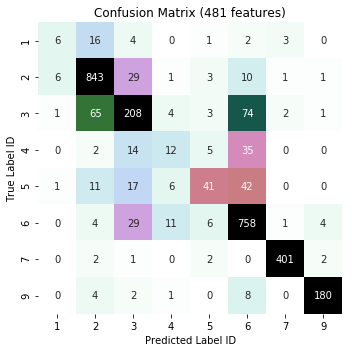

In [34]:

classLabels = ['1', '2', '3', '4', '5', '6', '7', '9']

print confuseMatrix.shape
normConfuseMatrix = np.zeros(confuseMatrix.shape)
for col in np.arange(confuseMatrix.shape[1]):
    normConfuseMatrix[:,col] = confuseMatrix[:,col] / float(confuseMatrix[:,col].max())

#turn the matrix into a dataframe    
#dfCM = pd.DataFrame(normConfuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])
dfCM = pd.DataFrame(confuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])

#plot the confusion matrix visually using a heatmap
colormap = plt.cm.cubehelix_r
fig = plt.figure(figsize=(5,5)) # (width, height)
sns.heatmap(dfCM, annot=True, vmin = 0, vmax = 100, fmt='d', cbar=False, cmap = colormap)
#sns.heatmap(dfCM, annot=True, cbar=False)
plt.xlabel('Predicted Label ID')
plt.ylabel('True Label ID')
plt.title('Confusion Matrix (%d features)'%(preProcFeats.shape[1]))

plt.tight_layout()
plt.savefig('confusion_matrix.png')

**Feature Importance**

Plots a graph of the 

In [35]:
fitModel = clf.fit(preProcFeats, preProcLabels)

1 DMstd 0.0306829850291
2 longestRunmaxRun 0.0704813676557
3 SNRstd 0.0345053320174
4 DMmin 0.0251397742226
5 SNRstd 0.0269243789102
6 windDedispTimeStatsmeansum 0.0464510241694
7 pixelMin_3_1 0.0429335549625
8 pixelstatsmeanmedian 0.0344663784064


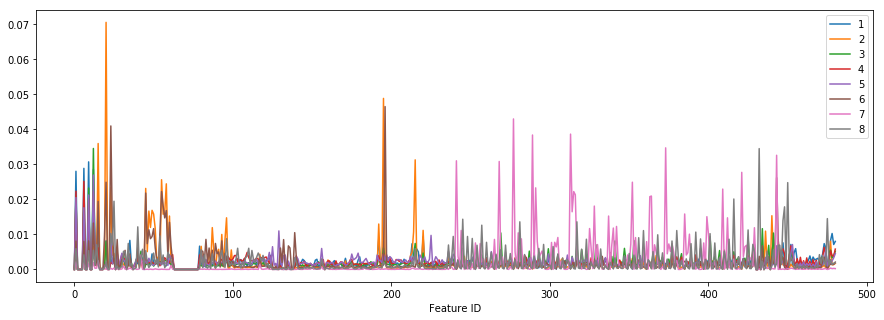

In [36]:
featureStrs = featureDf.columns.values

fimps = []

fig = plt.figure(figsize=(15,5)) # (width, height)
for idx in np.arange(len(fitModel.estimators_)):
    maxFeatVal = fitModel.estimators_[idx].feature_importances_.max() #find the feature with most importance
    
    #plot the importance of each feature (for each estimator, labelled by line colour)
    plt.plot(fitModel.estimators_[idx].feature_importances_, label=idx+1)
    
    #save feature importance array
    fimps.append(fitModel.estimators_[idx].feature_importances_)
    
    #plt.plot(fitModel.estimators_[idx].feature_importances_.clip(1e-2, maxFeatVal), label=idx+1)
    #plt.semilogy(fitModel.estimators_[idx].feature_importances_.clip(1e-3, maxFeatVal), label=idx+1)
    
    #for each estimator 1-8 prints the number, the feature with the highest importance, the features max importance
    print idx+1, featureStrs[np.argmax(fitModel.estimators_[idx].feature_importances_)], maxFeatVal

plt.legend()
plt.xlabel('Feature ID')

In [37]:
print fitModel.predict_proba(preProcFeats)[:10]

[[ 0.61842105  0.34210526  0.02631579  0.          0.01315789  0.          0.
   0.        ]
 [ 0.0125      0.925       0.05        0.          0.          0.          0.
   0.0125    ]
 [ 0.02531646  0.05063291  0.          0.          0.92405063  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.        ]
 [ 0.          0.96153846  0.01282051  0.          0.02564103  0.          0.
   0.        ]
 [ 0.67088608  0.01265823  0.          0.          0.3164557   0.          0.
   0.        ]
 [ 0.79012346  0.16049383  0.02469136  0.          0.02469136  0.          0.
   0.        ]
 [ 0.2195122   0.7804878   0.          0.          0.          0.          0.
   0.        ]
 [ 0.27380952  0.71428571  0.          0.          0.01190476  0.          0.
   0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.        ]]


In [38]:
predictProb = fitModel.predict_proba(preProcFeats)

#### Drop Features with under $25\%$ of max feature importance

In [39]:
fimpmax = np.zeros(8)
totalfimp = np.zeros(fimps[1].shape)
lessfeats = []
highimps = np.array([])

for idx in range(len(fimps)):
    fimpmax[idx] = fimps[idx].max()
    fimp = fimps[idx]
    highimp = np.argwhere(fimp > 0.3*fimpmax[idx])
    highimp = highimp.flatten()
    highimps = np.append(highimps, highimp)

delidx = np.unique(highimps)
allidx = np.arange(preProcFeats.shape[1])

delfeats = np.delete(allidx, delidx)
highfeats = np.delete(preProcFeats, delfeats, axis=1)

print 'highfeats' + str(highfeats.shape)


# for idx in range(len(fimps)):
#     fimpmax[idx] = fimps[idx].max()
#     fimp = fimps[idx]
#     totalfimp += fimp

# fimpmaxsum = sum(fimpmax)

# lowimp = np.argwhere(totalfimp < 0.5*fimpmaxsum)
# #args are sorted in ascending order so i need to flip to descending order 
# lowimp = np.flip(lowimp, 0)
# lowimp = lowimp.flatten()
# print lowimp
# lessfeats = np.delete(preProcFeats, lowimp, axis=1)
# print 'lessfeats' + str(lessfeats.shape)

highfeats(11543, 60)


/home/inigo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


#### Redo confusion matrix and importance graph with fewer features

In [40]:
print sklearn.model_selection.cross_val_score(clf, highfeats, preProcLabels,\
                                              cv=k_fold, n_jobs=-1, scoring='neg_log_loss')


# Train/Test Validation
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(highfeats,\
                                                            preProcLabels, test_size=0.25, random_state=420) #one quarter of data used for testing
predictTestX = clf.fit(X_train, y_train).predict_proba(X_test) #return an array of predicted values
confuseMatrixred = sklearn.metrics.confusion_matrix(y_test, clf.fit(X_train, y_train).predict(X_test))
print confuseMatrix

[-0.61545032 -0.65880543 -0.62973511]
[[  6  16   4   0   1   2   3   0]
 [  6 843  29   1   3  10   1   1]
 [  1  65 208   4   3  74   2   1]
 [  0   2  14  12   5  35   0   0]
 [  1  11  17   6  41  42   0   0]
 [  0   4  29  11   6 758   1   4]
 [  0   2   1   0   2   0 401   2]
 [  0   4   2   1   0   8   0 180]]


(8, 8)


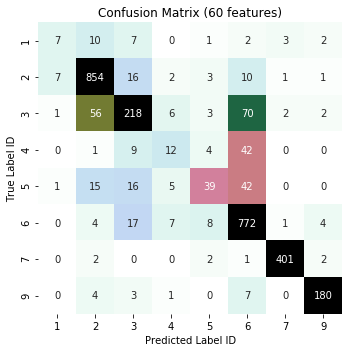

In [41]:
classLabels = ['1', '2', '3', '4', '5', '6', '7', '9']

print confuseMatrixred.shape
normConfuseMatrixred = np.zeros(confuseMatrixred.shape)
for col in np.arange(confuseMatrixred.shape[1]):
    normConfuseMatrixred[:,col] = confuseMatrixred[:,col] / float(confuseMatrixred[:,col].max())

#turn the matrix into a dataframe    
#dfCM = pd.DataFrame(normConfuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])
dfCM = pd.DataFrame(confuseMatrixred, index = [i for i in classLabels], columns = [i for i in classLabels])

#plot the confusion matrix visually using a heatmap
colormap = plt.cm.cubehelix_r
fig = plt.figure(figsize=(5,5)) # (width, height)
sns.heatmap(dfCM, annot=True, vmin = 0, vmax = 100, fmt='d', cbar=False, cmap = colormap)
#sns.heatmap(dfCM, annot=True, cbar=False)
plt.xlabel('Predicted Label ID')
plt.ylabel('True Label ID')
plt.title('Confusion Matrix %d -> %d features)'%(preProcFeats.shape[1], highfeats.shape[1]))

plt.tight_layout()
plt.savefig('confusion_matrix25.png')

#### Take the difference between the confusion matrices

**Feature Importance**

Plots a graph of the 

[[  1  -6   3   0   0   0   0   2]
 [  1  11 -13   1   0   0   0   0]
 [  0  -9  10   2   0  -4   0   1]
 [  0  -1  -5   0  -1   7   0   0]
 [  0   4  -1  -1  -2   0   0   0]
 [  0   0 -12  -4   2  14   0   0]
 [  0   0  -1   0   0   1   0   0]
 [  0   0   1   0   0  -1   0   0]]


/home/inigo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


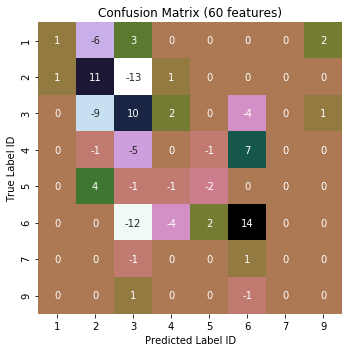

In [42]:
confuseMatrixdiff = confuseMatrixred - confuseMatrix
print confuseMatrixdiff

normConfuseMatrixdiff = np.zeros(confuseMatrixdiff.shape)
for col in np.arange(confuseMatrixdiff.shape[1]):
    normConfuseMatrixdiff[:,col] = confuseMatrixdiff[:,col] / float(confuseMatrixdiff[:,col].max())

#turn the matrix into a dataframe    
#dfCM = pd.DataFrame(normConfuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])
dfCM = pd.DataFrame(confuseMatrixdiff, index = [i for i in classLabels], columns = [i for i in classLabels])

#Plot the confusion matrix visually using a heatmap:
colormap = plt.cm.cubehelix_r
fig = plt.figure(figsize=(5,5)) # (width, height)
sns.heatmap(dfCM, annot=True, fmt='d', cbar=False, cmap = colormap)
#sns.heatmap(dfCM, annot=True, cbar=False)
plt.xlabel('Predicted Label ID')
plt.ylabel('True Label ID')
plt.title('Confusion Matrix (%d features)'%(highfeats.shape[1]))

plt.tight_layout()
plt.savefig('confusion_matrix25diff.png')